# Depth-frequency plots

Loads depth-frequency-time data and then plots time-averaged depth-frequency power.

## Imports
Necessary modules for analysis.

In [91]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as pldates
import numpy as np
for i in range(2):
    %matplotlib notebook

In [162]:
# import data

adcp = 'Axis55'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2018
ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')

n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]

#print(ds)

In [163]:
# extract plotting variables

t_stamp = int(ds[0].t_stamp)
start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                     # input end date in YYYY,MM,DD
depth = ds[0].depth.values
d = len(depth)

## Depth-frequency PSD plots

In [164]:
# time-average at each depth

t_tot = 0                          # for weighted averaging
for i in range(n_seg):
    t_tot += len(ds[i].spect)

Sxxu_t,Sxxv_t = [],[]
for i in range(n_seg):
    t_weight = (len(ds[i].spect)) / t_tot
    Sxxu_temp = ds[i].Sxxu.mean(dim='spect') * t_weight
    Sxxu_t.append(np.asarray(Sxxu_temp.values))
    Sxxv_temp = ds[i].Sxxv.mean(dim='spect') * t_weight
    Sxxv_t.append(np.asarray(Sxxv_temp.values))
    
Sxxu_tm,Sxxv_tm = [Sxxu_t[0]],[Sxxv_t[0]]
for i in range(1,n_seg):
    Sxxu_tm += Sxxu_t[i]
    Sxxv_tm += Sxxv_t[i]

In [165]:
# WKB scale at each depth

u_WKB,v_WKB = [],[]

for j in range(d):
    u_WKB.append(Sxxu_tm[0][j] / ds[0].WKB_scale[j].values)          # [list][depth][frequency]
    v_WKB.append(Sxxv_tm[0][j] / ds[0].WKB_scale[j].values)          # [list][depth][frequency]

In [ ]:
# plot PSD frequency band power versus depth

band = 'Tidal'           # Tidal, Subdiurnal, Continuum

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7.2,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.965, 0.5, 'PSD [(m/s)$^2$/Hz]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.02, 'Frequency [Hz]', ha='center',fontsize=14)
fig.text(0.21, 0.887, 'WKB-scaled', ha='center',fontsize=14)

if band == 'Tidal':
    ax1.set_xlim(1e-6,1e-4)
    for i in [ax0,ax1]:
        if adcp == 'Slope':
            pltdepth = -125
        elif adcp == 'Axis75' or adcp == 'Axis55':
            pltdepth = -720
        pltcolor = 'white'
        i.axvline(1.161e-5, color =pltcolor,lw=2,ls=(0,(1,3)),alpha=0.8) # constituents
        i.axvline(1.732e-5, color =pltcolor,lw=2,ls=(0,(1,3)),alpha=0.8)    
        i.axvline(2.236e-5, color =pltcolor,lw=2,ls=(0,(1,3)),alpha=0.8)
        i.text(0.90e-5,pltdepth,'K$_1$',fontsize=15,color=pltcolor)
        i.text(1.40e-5,pltdepth,'$f$',fontsize=15,color=pltcolor)
        i.text(2.30e-5,pltdepth,'M$_2$',fontsize=15,color=pltcolor)    
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e1
        vmax = 1e3
        fig.text(0.5, 0.887, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.5, 0.477, 'Along-canyon', ha='center', fontsize=14)
    elif adcp == 'Slope':
        vmin = 1e1
        vmax = 2e2
        fig.text(0.5, 0.887, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.5, 0.477, 'Along-slope', ha='center', fontsize=14)
    
im0 = ax0.pcolormesh(ds[0].specf, -depth, u_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
im1 = ax1.pcolormesh(ds[0].specf, -depth, v_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')
ax0.set_xscale('log')
ax1.set_xscale('log')

ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/depthfreq_plots/depthfreq_psd_{band}_{adcp}_{t_stamp}.pdf',format='pdf')

In [167]:
# save PSD data to .nc for inter-annual comparison

#for i in range(n_seg):
ds_out = xr.Dataset( 
    data_vars=dict(
        u_PSD_WKB=(['depth','specf'], u_WKB),        # low-pass data
        v_PSD_WKB=(['depth','specf'], v_WKB),
    ),
    coords=dict(
        depth=depth,                        # depth values
        specf=ds[0].specf.values,           # datetime values in segments
    ),
    attrs=dict(
        description=f'Depth-freq WKB PSD data for {adcp} {t_stamp}.',
        adcp=adcp,                   # adcp
        #upidx=upidx,                 # upper depth index
        #lowidx=lowidx,               # lower depth index
        #dup_stamp=dup_stamp,         # upper depth stamp
        #dlow_stamp=dlow_stamp,       # lower depth stamp
        t_stamp=t_stamp,             # year stamp
        #t=t,                         # length of time series
        #d=d,                         # length of depth series
        n_seg=n_seg,                 # total number of segments
    ),
) 
ds_out.to_netcdf(f'../Data/interannual/depthfreq_psd_{adcp}_{t_stamp}.nc')

## Depth-frequency rotary plots

In [168]:
# time-average at each depth

t_tot = 0                          # for weighted averaging
for i in range(n_seg):
    t_tot += len(ds[i].spect)

cw_t,ccw_t = [],[]
for i in range(n_seg):
    t_weight = (len(ds[i].spect)) / t_tot
    cw_temp = ds[i].cw.mean(dim='spect') * t_weight
    cw_t.append(np.asarray(cw_temp.values))
    ccw_temp = ds[i].ccw.mean(dim='spect') * t_weight
    ccw_t.append(np.asarray(ccw_temp.values))
    
cw_tm,ccw_tm = [cw_t[0]],[ccw_t[0]]
for i in range(1,n_seg):
    cw_tm += cw_t[i]
    ccw_tm += ccw_t[i]

In [169]:
# WKB scale at each depth

cw_WKB,ccw_WKB = [],[]

for j in range(d):
    cw_WKB.append(cw_tm[0][j] / ds[0].WKB_scale[j].values)          # [list][depth][frequency]
    ccw_WKB.append(ccw_tm[0][j] / ds[0].WKB_scale[j].values)          # [list][depth][frequency]

In [ ]:
# plot rotary frequency band power versus depth

fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7,6),sharey=True,sharex=True)
fig.subplots_adjust(hspace = 0.15)

fig.text(0.5, 0.94, f'{adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.965, 0.5, 'Rotary PSD [(m/s)$^2$/Hz]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.02, 'Frequency [Hz]', ha='center',fontsize=14)
fig.text(0.21, 0.887, 'WKB-scaled', ha='center',fontsize=14)

if adcp == 'Axis55' or adcp == 'Axis75':
    vmin = 1e1
    vmax = 1e3
elif adcp == 'Slope':
    vmin = 1e1
    vmax = 2e2

if band == 'Tidal':
    ax1.set_xlim(1e-6,1e-4)
    for i in [ax0,ax1]:
        if adcp == 'Slope':
            pltdepth = -125
        elif adcp == 'Axis75' or adcp == 'Axis55':
            pltdepth = -720
        pltcolor = 'white'
        i.axvline(1.161e-5, color =pltcolor,lw=2,ls=(0,(1,3)),alpha=0.8) # constituents
        i.axvline(1.732e-5, color =pltcolor,lw=2,ls=(0,(1,3)),alpha=0.8)    
        i.axvline(2.236e-5, color =pltcolor,lw=2,ls=(0,(1,3)),alpha=0.8)
        i.text(0.90e-5,pltdepth,'K$_1$',fontsize=15,color=pltcolor)
        i.text(1.40e-5,pltdepth,'$f$',fontsize=15,color=pltcolor)
        i.text(2.30e-5,pltdepth,'M$_2$',fontsize=15,color=pltcolor)    
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e1
        vmax = 1e3
    elif adcp == 'Slope':
        vmin = 1e1
        vmax = 2e2
elif band == 'Subdiurnal':
    ax1.set_xlim(1e-6,1e-5)
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 1e1
        vmax = 1e2
    elif adcp == 'Slope':
        vmin = 1e1
        vmax = 1e3
elif band == 'Continuum':
    ax1.set_xlim(7e-5,2e-4)
    if adcp == 'Axis55' or adcp == 'Axis75':
        vmin = 5e-1
        vmax = 5e0
    elif adcp == 'Slope':
        vmin = 5e-1
        vmax = 5e0 
        
fig.text(0.5, 0.887, 'CW', ha='center', fontsize=14)
fig.text(0.5, 0.477, 'CCW', ha='center', fontsize=14)    
    

im0 = ax0.pcolormesh(ds[0].specf, -depth, cw_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
im1 = ax1.pcolormesh(ds[0].specf, -depth, ccw_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')
ax0.set_xscale('log')
ax1.set_xscale('log')

ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/depthfreq_plots/depthfreq_rot_{band}_{adcp}_{t_stamp}.pdf',format='pdf')

In [171]:
# save rotary data to .nc for inter-annual comparison

#for i in range(n_seg):
ds_out = xr.Dataset( 
    data_vars=dict(
        cw_rot_WKB=(['depth','specf'], cw_WKB),        # low-pass data
        ccw_rot_WKB=(['depth','specf'], ccw_WKB),
    ),
    coords=dict(
        depth=depth,                        # depth values
        specf=ds[0].specf.values,           # datetime values in segments
    ),
    attrs=dict(
        description=f'Depth-freq WKB rotary data for {adcp} {t_stamp}.',
        adcp=adcp,                   # adcp
        #upidx=upidx,                 # upper depth index
        #lowidx=lowidx,               # lower depth index
        #dup_stamp=dup_stamp,         # upper depth stamp
        #dlow_stamp=dlow_stamp,       # lower depth stamp
        t_stamp=t_stamp,             # year stamp
        #t=t,                         # length of time series
        #d=d,                         # length of depth series
        n_seg=n_seg,                 # total number of segments
    ),
) 
ds_out.to_netcdf(f'../Data/interannual/depthfreq_rot_{adcp}_{t_stamp}.nc')

## Inter-annual comparisons

<IPython.core.display.Javascript object>


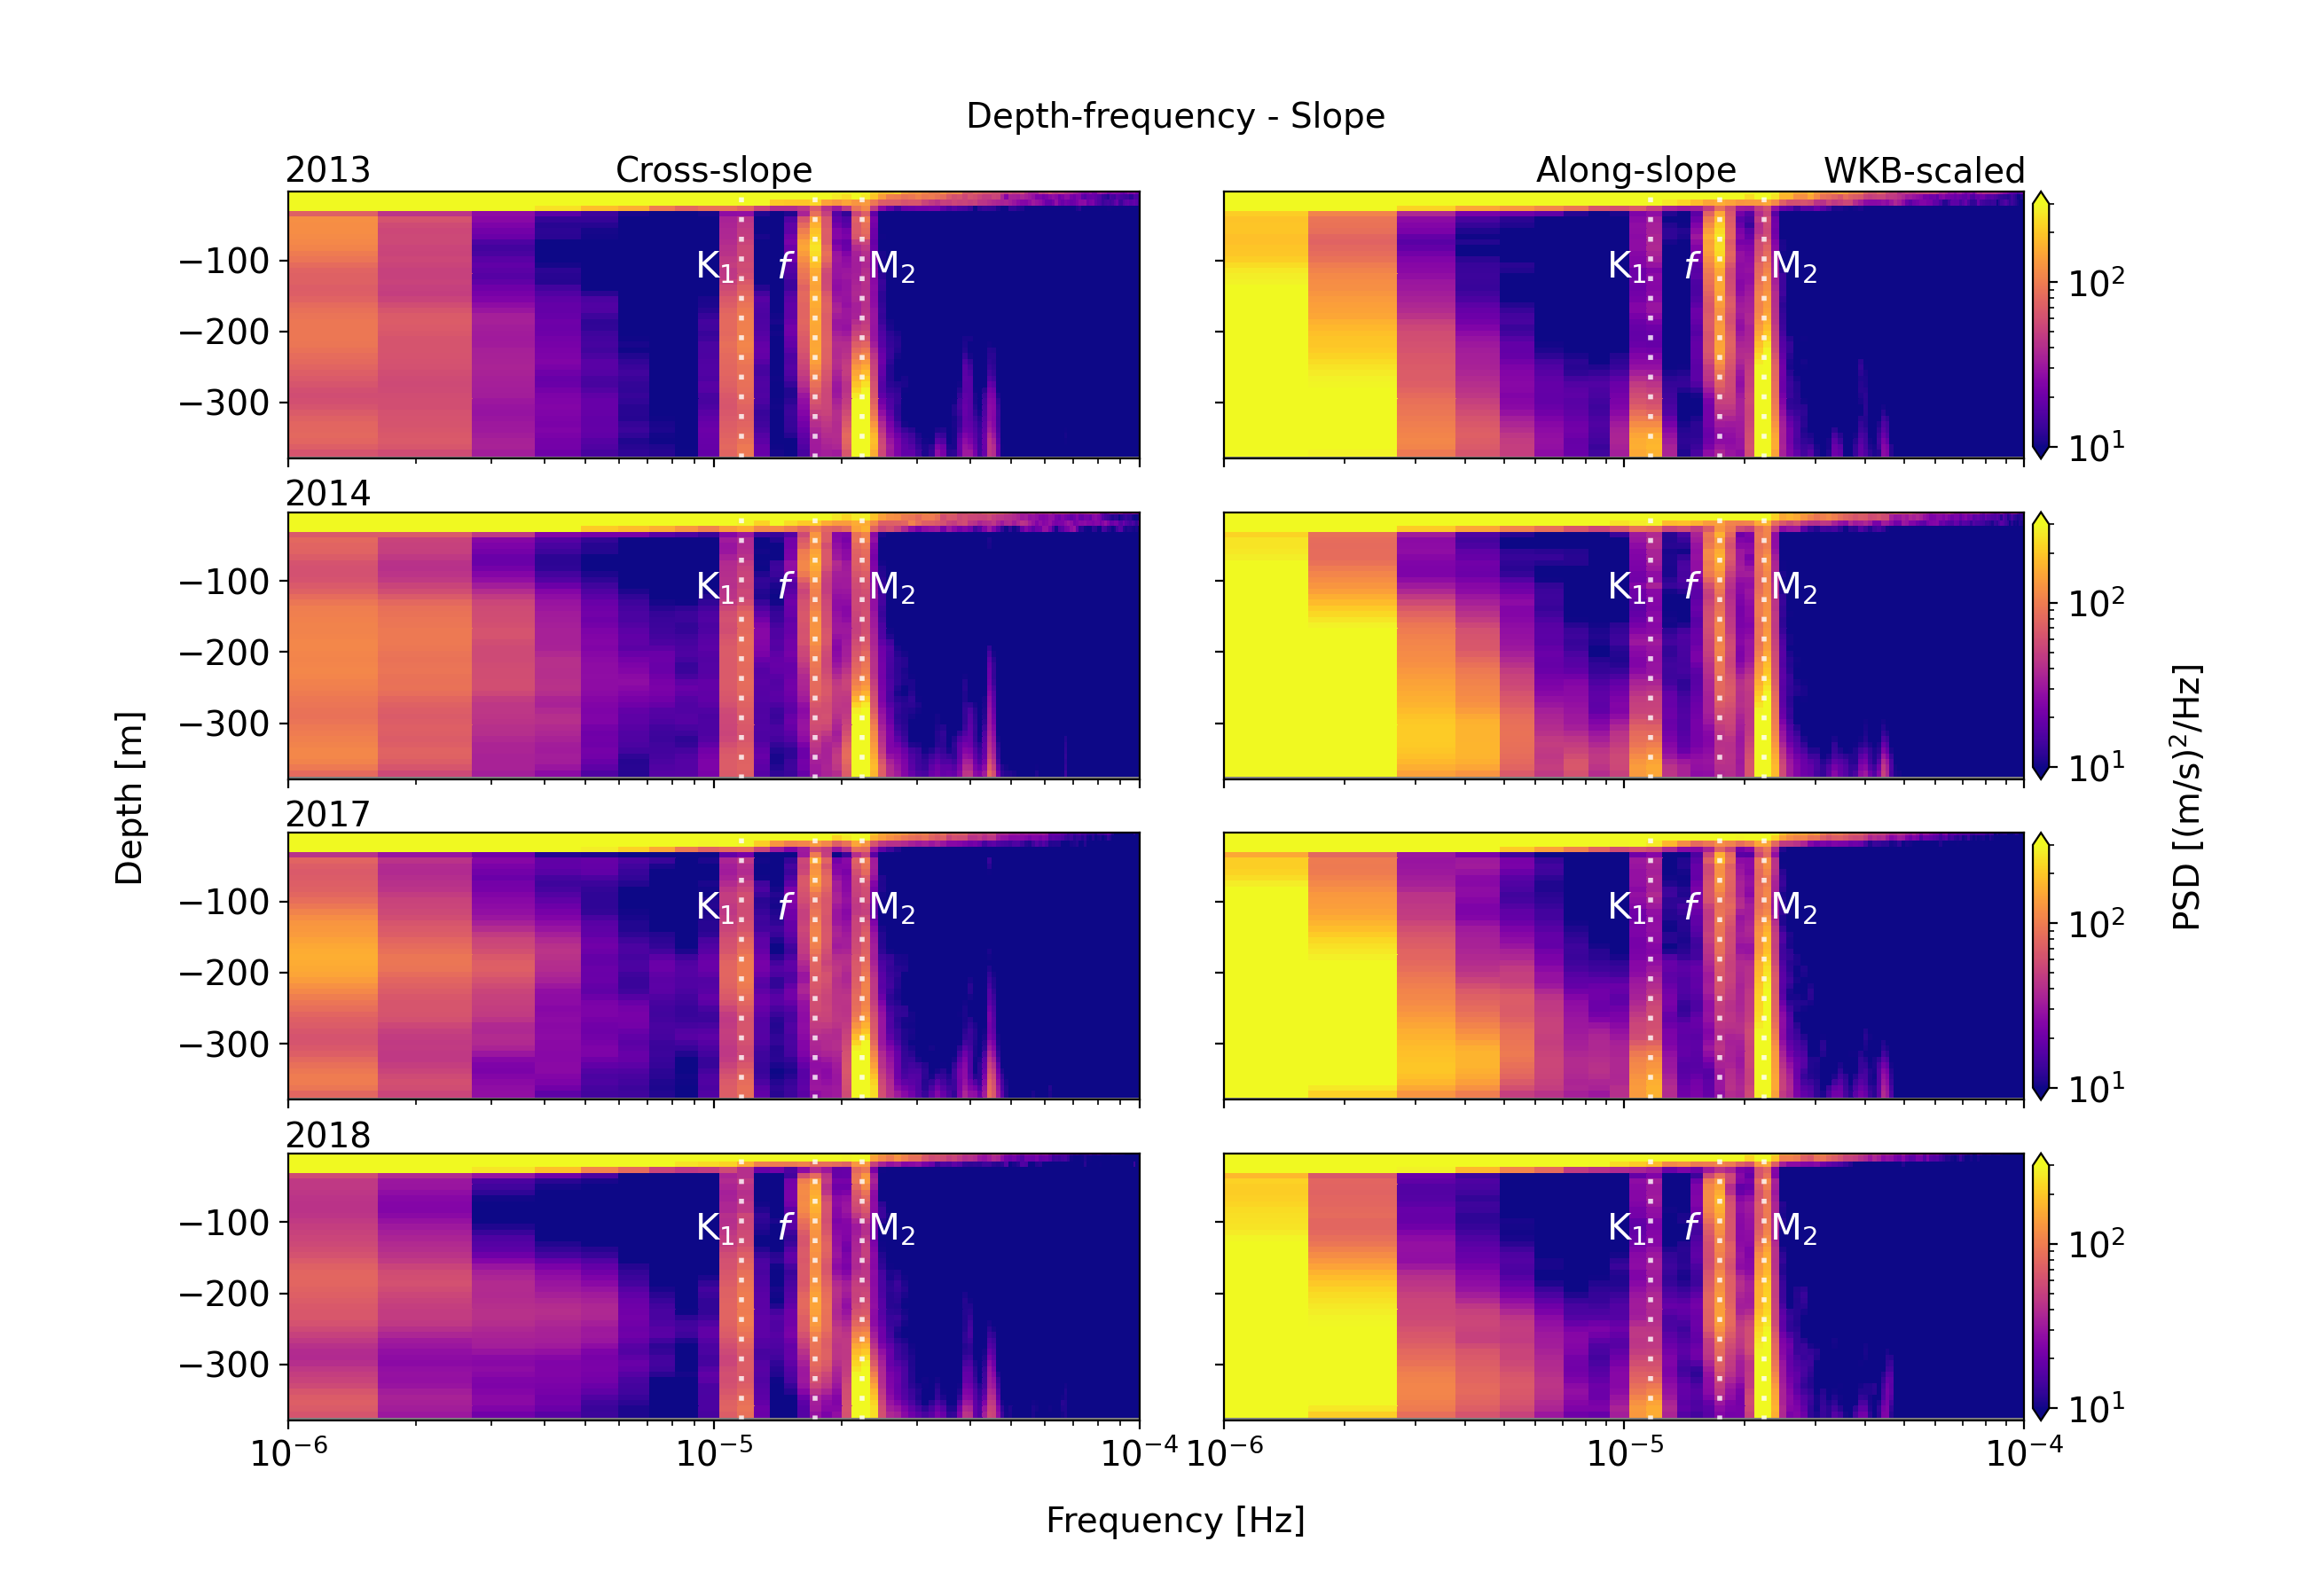

In [208]:
# import and plot PSD data

site = 'Slope'     # Slope or Axis

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013 = xr.open_dataset(f'../Data/interannual/depthfreq_psd_{site}_2013.nc')
    ds_2014 = xr.open_dataset(f'../Data/interannual/depthfreq_psd_{site}_2014.nc')
    ds_2017 = xr.open_dataset(f'../Data/interannual/depthfreq_psd_{site}_2017.nc')
    ds_2018 = xr.open_dataset(f'../Data/interannual/depthfreq_psd_{site}_2018.nc')
elif site == 'Axis':
    ds_2013 = xr.open_dataset(f'../Data/interannual/depthfreq_psd_Axis75_2013.nc')
    ds_2014 = xr.open_dataset(f'../Data/interannual/depthfreq_psd_Axis75_2014.nc')
    ds_2017 = xr.open_dataset(f'../Data/interannual/depthfreq_psd_Axis55_2017.nc')
    ds_2018 = xr.open_dataset(f'../Data/interannual/depthfreq_psd_Axis55_2018.nc')
    
#print(ds_2018[0])

# plot inter-annual PSD data

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = True, sharey = True)
fig.subplots_adjust(wspace = 0.1)

fig.text(0.51, 0.92, f'Depth-frequency - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.94, 0.5, 'PSD [(m/s)$^2$/Hz]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Frequency [Hz]', ha='center',fontsize=14)
fig.text(0.835, 0.886, 'WKB-scaled', ha='center',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()
    
axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
    
band = 'Tidal'           # Tidal
if band == 'Tidal':
    ax1.set_xlim(1e-6,1e-4)
    for i in axs:
        if site == 'Slope':
            pltdepth = -125
        elif site == 'Axis':
            pltdepth = -620
        pltcolor = 'white'
        i.axvline(1.161e-5, color =pltcolor,lw=2,ls=(0,(1,3)),alpha=0.8) # constituents
        i.axvline(1.732e-5, color =pltcolor,lw=2,ls=(0,(1,3)),alpha=0.8)    
        i.axvline(2.236e-5, color =pltcolor,lw=2,ls=(0,(1,3)),alpha=0.8)
        i.text(0.90e-5,pltdepth,'K$_1$',fontsize=15,color=pltcolor)
        i.text(1.40e-5,pltdepth,'$f$',fontsize=15,color=pltcolor)
        i.text(2.30e-5,pltdepth,'M$_2$',fontsize=15,color=pltcolor)    
    if site == 'Axis':
        vmin = 1e1
        vmax = 1e3
        fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 1e1
        vmax = 3e2
        fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
        
years = [ds_2013,ds_2014,ds_2017,ds_2018]  
for k,i in enumerate(years):
    if k == 0:
        im0 = ax0.pcolormesh(i.specf, -i.depth, i.u_PSD_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
        im1 = ax1.pcolormesh(i.specf, -i.depth, i.v_PSD_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto') 
        ax0.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')
        ax1.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')
    elif k == 1:
        im2 = ax2.pcolormesh(i.specf, -i.depth, i.u_PSD_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
        im3 = ax3.pcolormesh(i.specf, -i.depth, i.v_PSD_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto') 
        ax2.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')
        ax3.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')
    elif k == 2:
        im4 = ax4.pcolormesh(i.specf, -i.depth, i.u_PSD_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
        im5 = ax5.pcolormesh(i.specf, -i.depth, i.v_PSD_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto') 
        ax4.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')
        ax5.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')
    elif k == 3:
        im6 = ax6.pcolormesh(i.specf, -i.depth, i.u_PSD_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
        im7 = ax7.pcolormesh(i.specf, -i.depth, i.v_PSD_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto') 
        ax6.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')
        ax7.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

ax7.set_ylim(-ds_2013.depth[-1],-ds_2013.depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)
    i.set_xscale('log')

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/depthfreq_psd_{site}.pdf',format='pdf')

<IPython.core.display.Javascript object>


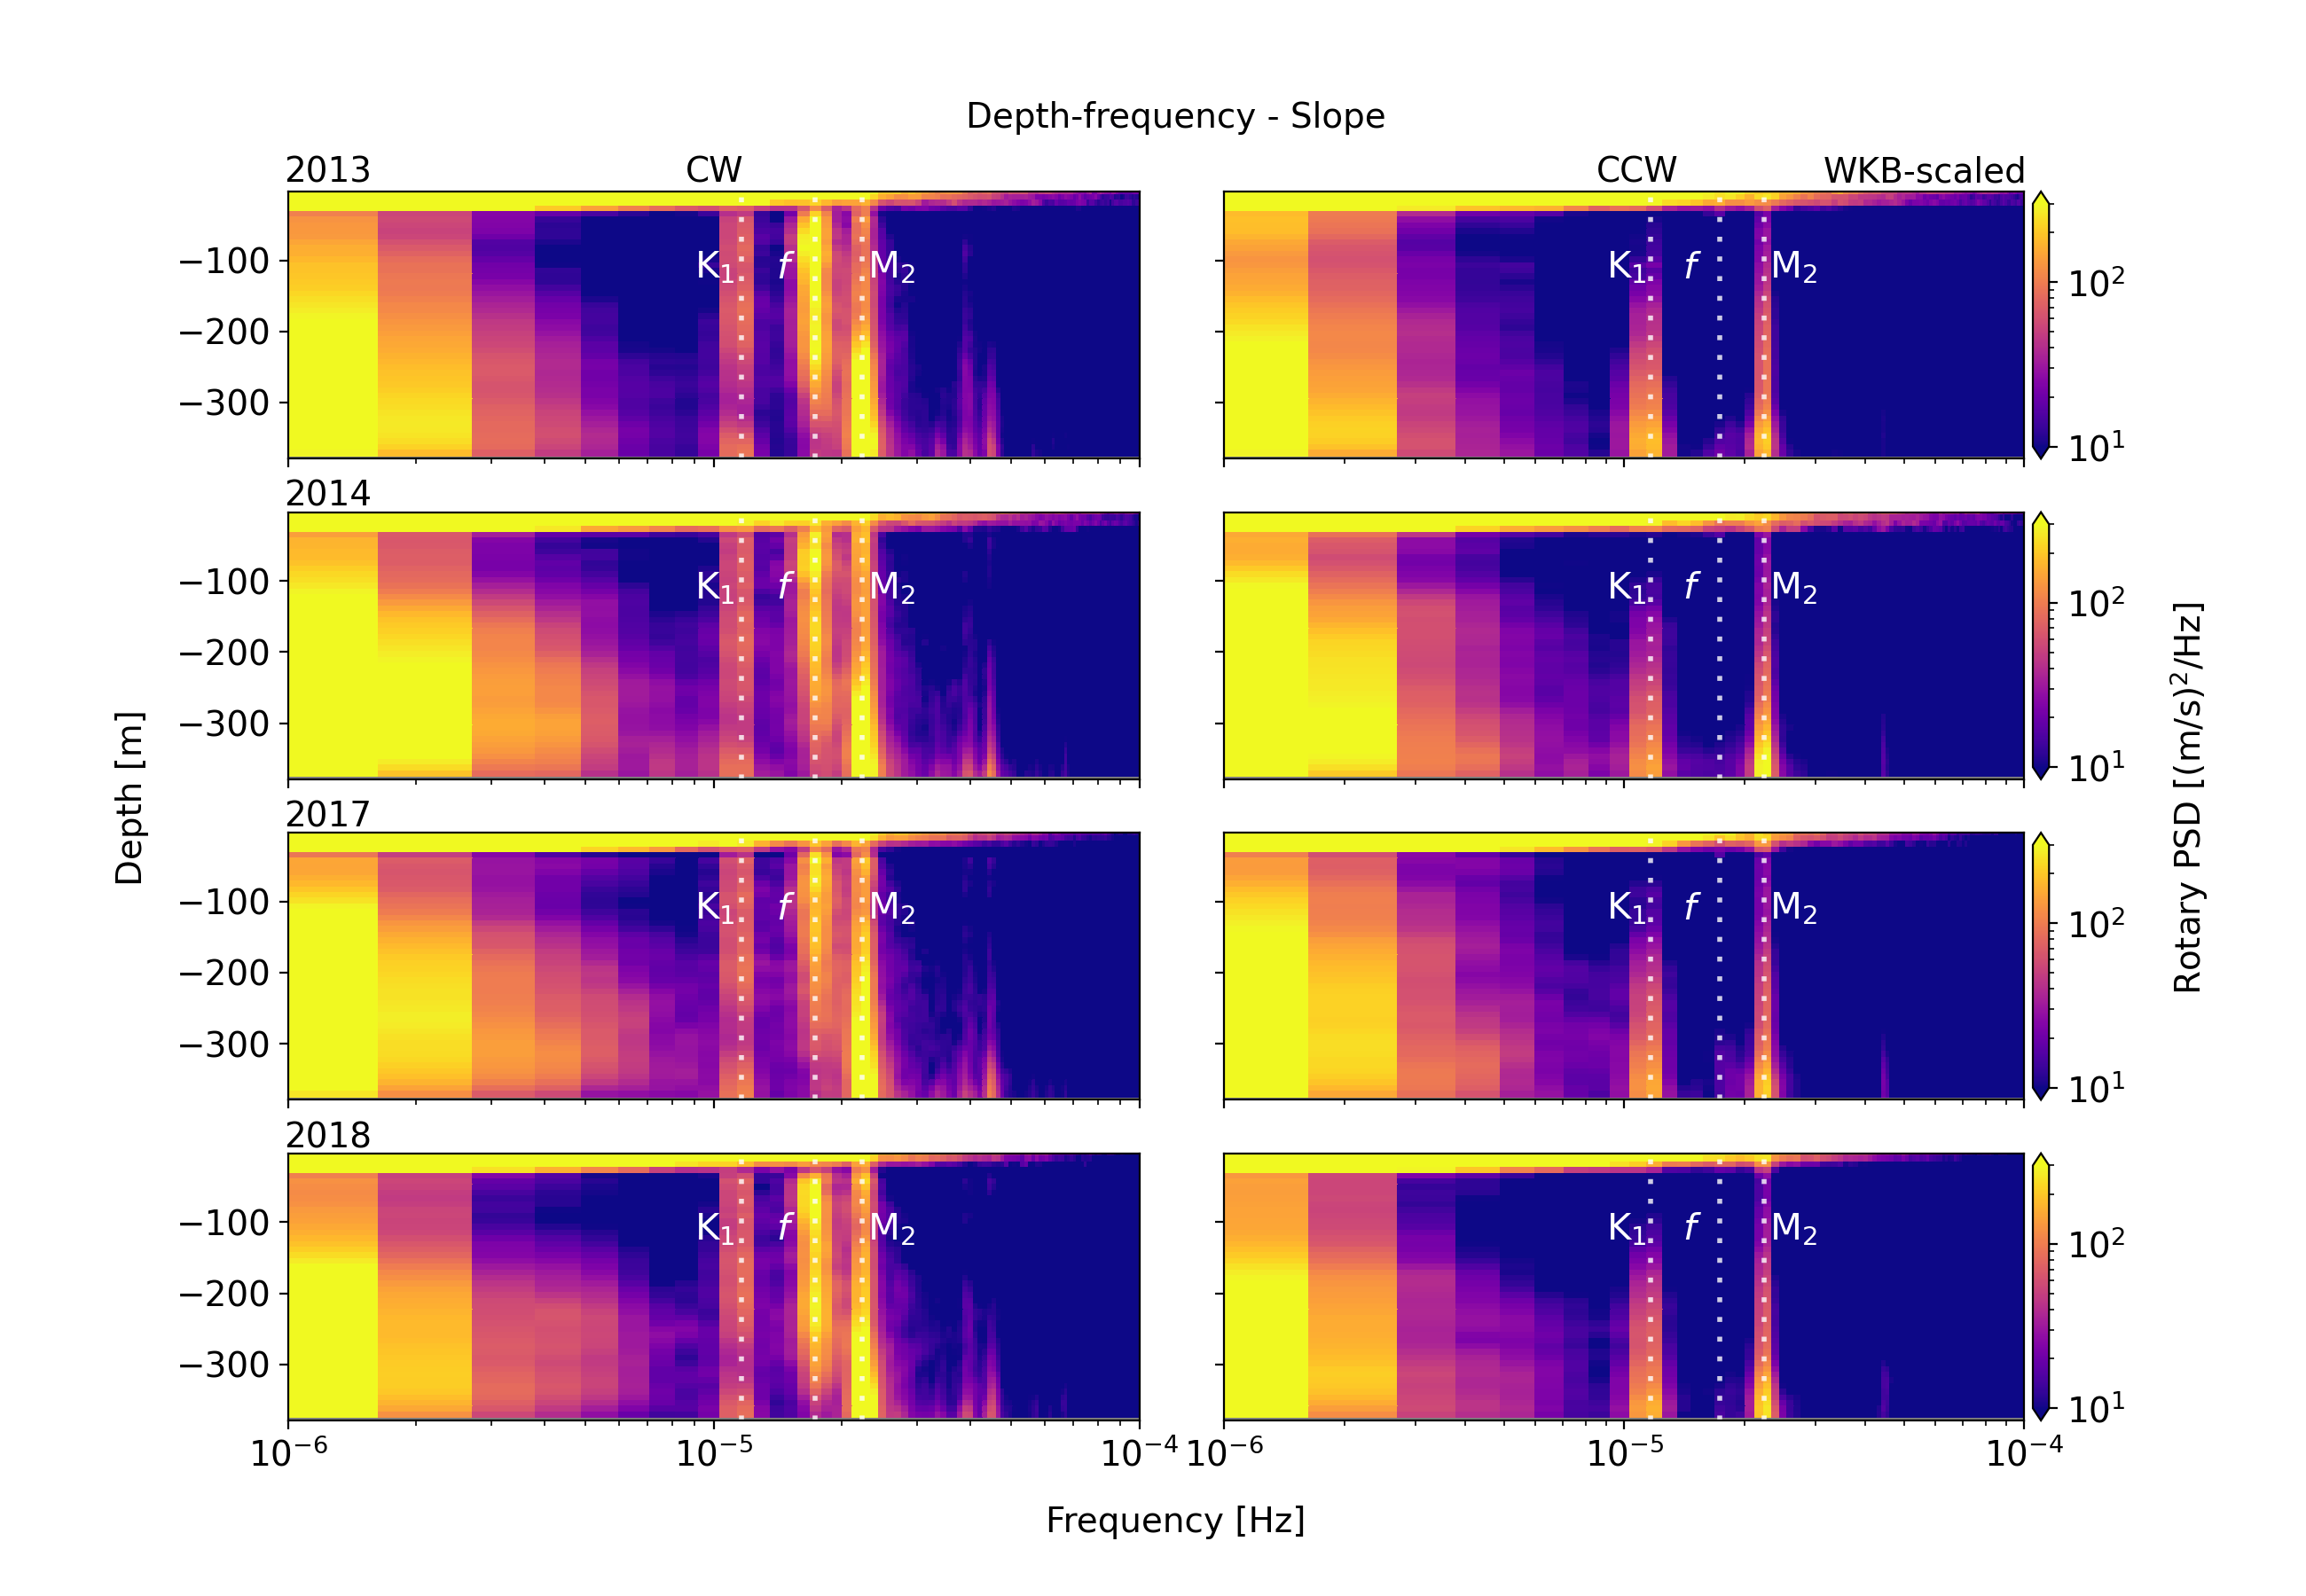

In [205]:
# import and plot rotary data

site = 'Slope'     # Slope or Axis

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013 = xr.open_dataset(f'../Data/interannual/depthfreq_rot_{site}_2013.nc')
    ds_2014 = xr.open_dataset(f'../Data/interannual/depthfreq_rot_{site}_2014.nc')
    ds_2017 = xr.open_dataset(f'../Data/interannual/depthfreq_rot_{site}_2017.nc')
    ds_2018 = xr.open_dataset(f'../Data/interannual/depthfreq_rot_{site}_2018.nc')
elif site == 'Axis':
    ds_2013 = xr.open_dataset(f'../Data/interannual/depthfreq_rot_Axis75_2013.nc')
    ds_2014 = xr.open_dataset(f'../Data/interannual/depthfreq_rot_Axis75_2014.nc')
    ds_2017 = xr.open_dataset(f'../Data/interannual/depthfreq_rot_Axis55_2017.nc')
    ds_2018 = xr.open_dataset(f'../Data/interannual/depthfreq_rot_Axis55_2018.nc')
    
#print(ds_2018[0])

# plot inter-annual rotary data

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = True, sharey = True)
fig.subplots_adjust(wspace = 0.1)

fig.text(0.51, 0.92, f'Depth-frequency - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.94, 0.5, 'Rotary PSD [(m/s)$^2$/Hz]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Frequency [Hz]', ha='center',fontsize=14)
fig.text(0.835, 0.886, 'WKB-scaled', ha='center',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()
    
axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
    
band = 'Tidal'           # Tidal
if band == 'Tidal':
    ax1.set_xlim(1e-6,1e-4)
    for i in axs:
        if site == 'Slope':
            pltdepth = -125
        elif site == 'Axis':
            pltdepth = -620
        pltcolor = 'white'
        i.axvline(1.161e-5, color =pltcolor,lw=2,ls=(0,(1,3)),alpha=0.8) # constituents
        i.axvline(1.732e-5, color =pltcolor,lw=2,ls=(0,(1,3)),alpha=0.8)    
        i.axvline(2.236e-5, color =pltcolor,lw=2,ls=(0,(1,3)),alpha=0.8)
        i.text(0.90e-5,pltdepth,'K$_1$',fontsize=15,color=pltcolor)
        i.text(1.40e-5,pltdepth,'$f$',fontsize=15,color=pltcolor)
        i.text(2.30e-5,pltdepth,'M$_2$',fontsize=15,color=pltcolor)    
    if site == 'Axis':
        vmin = 1e1
        vmax = 1e3
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
    elif site == 'Slope':
        vmin = 1e1
        vmax = 3e2
        fig.text(0.31, 0.886, 'CW', ha='center', fontsize=14)
        fig.text(0.71, 0.886, 'CCW', ha='center', fontsize=14)
        
years = [ds_2013,ds_2014,ds_2017,ds_2018]  
for k,i in enumerate(years):
    if k == 0:
        im0 = ax0.pcolormesh(i.specf, -i.depth, i.cw_rot_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
        im1 = ax1.pcolormesh(i.specf, -i.depth, i.ccw_rot_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto') 
        ax0.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')
        ax1.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')
    elif k == 1:
        im2 = ax2.pcolormesh(i.specf, -i.depth, i.cw_rot_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
        im3 = ax3.pcolormesh(i.specf, -i.depth, i.ccw_rot_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto') 
        ax2.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')
        ax3.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')
    elif k == 2:
        im4 = ax4.pcolormesh(i.specf, -i.depth, i.cw_rot_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
        im5 = ax5.pcolormesh(i.specf, -i.depth, i.ccw_rot_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto') 
        ax4.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')
        ax5.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')
    elif k == 3:
        im6 = ax6.pcolormesh(i.specf, -i.depth, i.cw_rot_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto')  
        im7 = ax7.pcolormesh(i.specf, -i.depth, i.ccw_rot_WKB, rasterized=True, \
                        norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',shading='auto') 
        ax6.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')
        ax7.hlines(y=-650, xmin=i.specf[0],xmax=i.specf[-1], linewidth=1, color='white', ls='--')

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

ax7.set_ylim(-ds_2013.depth[-1],-ds_2013.depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)
    i.set_xscale('log')

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/depthfreq_rot_{site}.pdf',format='pdf')